# Normative modelling as site effect correction tool

This tutorial will walk you through the application of normative modelling as site effect correction tool.

You will learn:
- How to fit a normative model to data from different sites.
- Choices that can be made about a normative model in a site effect context.
- How to transfer data from one site into another.
- How to make predictions for unseen sites and the rationale behind it.

# Quick recap: normative models using the pcn toolkit
A normative model requires three input variables:
- covariates (the X axis, ususally age)
- response variables (usually one or several brain feature measurements)
- a batch effect file. Batch effects can be anything that interferes with the covrariate (sex, site)

While the blr model reuiqres input of the batch effects via a design matrix, the implementation of the hbr only reuires a file.

In [1]:
# Import relevant libraries
import os
import pandas as pd
import pcntoolkit as ptk
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
import pdb

In [2]:
# a simple function to quickly load pickle files
def ldpkl(filename: str):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [2]:
# Quick check wehere you are in your directory.
!pwd

/Users/johbay/Dropbox/OHBM2024/educational-course


In [3]:
# create working dir
root_dir = os.getcwd()

In [5]:
print(root_dir)

/Users/johbay/Dropbox/OHBM2024/educational-course


In [4]:
processing_folder = "Site_effect_tutorial/"
os.chdir(processing_folder)

In [ ]:
if not os.path.isdir(processing_folder):
    os.makedirs(processing_folder)

In [5]:
processing_dir = os.getcwd()
print(f"The processing directory is: {processing_dir}")

The processing directory is: /Users/johbay/Dropbox/OHBM2024/educational-course/Site_effect_tutorial


# 01. Data pre-processing.

### Load the data

For this tutorial, we use publicly availabe data that has been pooled from various data sets.

In [ ]:
# Load the data
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_tr.csv
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_te.csv

In [6]:
# Load the test data into the notebook
test_data = os.path.join(root_dir, 'fcon1000_te.csv')
df_te = pd.read_csv(test_data, index_col=0)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(df_te['site'].to_list()))

In [7]:
# Load the training data into the notebook
train_data = os.path.join(root_dir, 'fcon1000_tr.csv')

df_tr = pd.read_csv(train_data, index_col=0)

# extract a list of unique site ids from the test set
site_ids_ad =  sorted(set(df_tr['site'].to_list()))

if not all(elem in site_ids_ad for elem in site_ids_te):
    print('Warning: some of the testing sites are not in the adaptation data')

### Make a quick display of the age distibution per site.

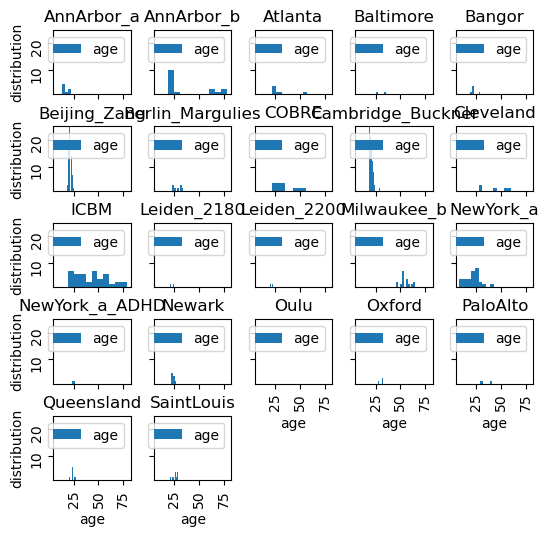

In [224]:
# Make a quick and dirty plot of the age distibution per site.
axes = df_tr.hist(['age'], by='site', layout=(5,5),
                  legend=True, yrot=90,sharex=True,sharey=True, 
                  figsize=(6,6))

for ax in axes.flatten():
    ax.set_xlabel('age')
    ax.set_ylabel('distribution')
    ax.set_ylim(bottom=1,top=25)

### Additionally, print the number of subjects per site.

In [8]:
sites = df_tr['site'].unique()

print('sample size check')
for i,s in enumerate(sites):
    idx = df_tr['site'] == s
    idxte = df_te['site'] == s
    print(i,s, sum(idx), sum(idxte))


sample size check
0 AnnArbor_a 13 11
1 AnnArbor_b 20 12
2 Atlanta 11 17
3 Baltimore 12 11
4 Bangor 10 10
5 Beijing_Zang 100 98
6 Berlin_Margulies 15 11
7 Cambridge_Buckner 94 104
8 Cleveland 11 20
9 ICBM 47 38
10 Leiden_2180 6 6
11 Leiden_2200 9 10
12 Milwaukee_b 26 20
13 NewYork_a 36 47
14 NewYork_a_ADHD 7 18
15 Newark 12 7
16 Oulu 60 42
17 Oxford 10 12
18 PaloAlto 7 9
19 Queensland 12 7
20 SaintLouis 18 13
21 COBRE 20 126


In [9]:
df_tr['sitenum'] = 0
for i,s in enumerate(sites):
    idx = df_tr['site'] == s
    df_tr['sitenum'].loc[idx] = i

    print('site',s, sum(idx))

site AnnArbor_a 13
site AnnArbor_b 20
site Atlanta 11
site Baltimore 12
site Bangor 10
site Beijing_Zang 100
site Berlin_Margulies 15
site Cambridge_Buckner 94
site Cleveland 11
site ICBM 47
site Leiden_2180 6
site Leiden_2200 9
site Milwaukee_b 26
site NewYork_a 36
site NewYork_a_ADHD 7
site Newark 12
site Oulu 60
site Oxford 10
site PaloAlto 7
site Queensland 12
site SaintLouis 18
site COBRE 20


/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/1108558262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/1108558262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/1108558262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [11]:
df_te['sitenum'] = 0
for i,s in enumerate(sites):
    idx = df_te['site'] == s
    df_te['sitenum'].loc[idx] = i

    print('site',s, sum(idx))

site AnnArbor_a 11
site AnnArbor_b 12
site Atlanta 17
site Baltimore 11
site Bangor 10
site Beijing_Zang 98
site Berlin_Margulies 11
site Cambridge_Buckner 104
site Cleveland 20
site ICBM 38
site Leiden_2180 6
site Leiden_2200 10
site Milwaukee_b 20
site NewYork_a 47
site NewYork_a_ADHD 18
site Newark 7
site Oulu 42
site Oxford 12
site PaloAlto 9
site Queensland 7
site SaintLouis 13
site COBRE 126


/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/2191059795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/2191059795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_95488/2191059795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

### Set aside hold-out transfer sites.
For our site transfer later we want to exclude some sites from the training and test set for later. We choose the SaintLois and the COBRE site and remove them from the training and test set. We summarize those sites in a `new_sites_tr` and `new_sites_te` variable.

In [12]:
# Save some sites for later, these are going to be my new sites
new_sites_tr = df_tr[(df_tr['site']== 'SaintLouis')| (df_tr['site']=='COBRE')]
new_sites_te = df_te[(df_te['site']== 'SaintLouis')| (df_te['site']=='COBRE')]

In [13]:
new_sites_te.shape

(139, 223)

In [14]:
# Remove those sites from the training and test sets
df_tr = df_tr[df_tr.site != 'SaintLouis']
df_tr = df_tr[df_tr.site != 'COBRE']
df_te = df_te[df_te.site != 'SaintLouis']
df_te = df_te[df_te.site != 'COBRE']
len(df_tr["site"].unique())

20

# Selecting brain variables (independently derived phenotypes, IDPs).

Our data set contains 223 columns. We select two phenotypes for modelling. 

In [15]:
# Select the IDPs (columns) of interest from the data frame
idps = ['lh_G&S_frontomargin_thickness','rh_G&S_frontomargin_thickness']

In [16]:
# Prepare the data frames for training and testing

X_train = (df_tr['age']/100).to_numpy(dtype=float) # we rescale age to range between [0,1]
Y_train = df_tr[idps].to_numpy(dtype=float)
batch_effects_train = df_tr[['sitenum', 'sex']].to_numpy(dtype=int)

#test_data[['site_id','sex']].to_numpy(dtype=float)

# save data
with open('X_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_train), file)
with open('Y_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_train), file)
with open('trbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_train), file)


X_test = (df_te['age']/100).to_numpy(dtype=float)
Y_test = df_te[idps].to_numpy(dtype=float)
batch_effects_test = df_te[['sitenum', 'sex']].to_numpy(dtype=int)

#save data
with open('X_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test), file)
with open('Y_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test), file)
with open('tsbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test), file)

# a simple function to quickly load pickle files
def ldpkl(filename: str):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [17]:
# the model needs the paths to the data. create them here

respfile = os.path.join(processing_dir, 'Y_train.pkl')       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = os.path.join(processing_dir, 'X_train.pkl')        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = os.path.join(processing_dir, 'Y_test.pkl')       # measurements  for the testing samples
testcovfile_path = os.path.join(processing_dir, 'X_test.pkl')        # covariate file for the testing samples

trbefile = os.path.join(processing_dir, 'trbefile.pkl')      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = os.path.join(processing_dir, 'tsbefile.pkl')      # testing batch effects file

output_path = os.path.join(processing_dir, 'Models/')    #  output path, where the models will be written
log_dir = os.path.join(processing_dir, 'log/')           # log path
if not os.path.isdir(output_path):
    os.mkdir(output_path)
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = 'estimate'      # a string to name the output files, of use only to you, so adapt it for your needs.

# 02. Normative modelling
## Case 1: Training a nomrative model on different sites and make predictions on the same sites (equal distribution of sites in training and test data)

Use: Hierarchical Bayesian model (HBR)

HBR multi-batch normative modelling class. By default, this function
 |  estimates a linear model with random intercept, random slope, and random
 |  homoscedastic noise.
 |  
 |  :param X: [N×P] array of clinical covariates
 |  :param y: [N×1] array of neuroimaging measures
 |  :param trbefile: the address to the batch effects file for the training set.
 |      the batch effect array should be a [N×M] array where M is the number of
 |      the type of batch effects. For example when the site and gender is modeled
 |      as batch effects M=2. Each column in the batch effect array contains the
 |      batch ID (starting from 0) for each sample. If not specified (default=None)
 |      then all samples assumed to be from the same batch (i.e., the batch effect
 |                                                          is not modelled).
 |  :param tsbefile: Similar to trbefile for the test set.
 |  :param model_type: Specifies the type of the model from 'linear', 'plynomial',
 |      and 'bspline' (defauls is 'linear').
 |  :param likelihood: specifies the type of likelihood among 'Normal' 'SHASHb','SHASHo',
 |      and 'SHASHo2' (defauls is normal).
 |  :param linear_mu: Boolean (default='True') to decide whether the mean (mu) is
 |      parametrized on a linear function (thus changes with covariates) or it is fixed.
 |  :param linear_sigma: Boolean (default='False') to decide whether the variance (sigma) is
 |      parametrized on a linear function (heteroscedastic noise) or it is fixed for
 |      each batch (homoscedastic noise).
 |  :param linear_epsilon: Boolean (default='False') to decide the parametrization
 |      of epsilon for the SHASH likelihood that controls its skewness.
 |      If True, epsilon is  parametrized on a linear function
 |      (thus changes with covariates) otherwise it is fixed for each batch.
 |  :param linear_delta: Boolean (default='False') to decide the parametrization
 |      of delta for the SHASH likelihood that controls its kurtosis.
 |      If True, delta is  parametrized on a linear function
 |      (thus changes with covariates) otherwise it is fixed for each batch.
 |  :param random_intercept_{parameter}: if parameters mu (default='True'),
 |      sigma (default='False'), epsilon (default='False'), and delta (default='False')
 |      are parametrized on a linear function, then this boolean decides
 |      whether the intercept can vary across batches.
 |  :param random_slope_{parameter}: if parameters mu (default='True'),
 |      sigma (default='False'), epsilon (default='False'), and delta (default='False')
 |      are parametrized on a linear function, then this boolean decides
 |      whether the slope can vary across batches.
 |  :param centered_intercept_{parameter}: if parameters mu (default='False'),
 |      sigma (default='False'), epsilon (default='False'), and delta (default='False')
 |      are parametrized on a linear function, then this boolean decides
 |      whether the parameters of intercept are estimated in a centered or
 |      non-centered manner (default). While centered estimation runs faster
 |      it may cause some problems for the sampler (the funnel of hell).
 |  :param centered_slope_{parameter}: if parameters mu (default='False'),
 |      sigma (default='False'), epsilon (default='False'), and delta (default='False')
 |      are parametrized on a linear function, then this boolean decides
 |      whether the parameters of slope are estimated in a centered or
 |      non-centered manner (default). While centered estimation runs faster
 |      it may cause some problems for the sampler (the funnel of hell).
 |  :param sampler: specifies the type of PyMC sampler (Defauls is 'NUTS').
 |  :param n_samples: The number of samples to draw (Default is '1000'). Please
 |      note that this parameter must be specified in a string fromat ('1000' and
 |                                                                     not 1000).



# Selecting the model



We decide for out model that we want the mean and the variance to vary with the covariate (linear_mu and linear_sigma, respectively). Given that our dataset is quite small, we decide to use a model with a normal likelihood (the default). More complex likelihood choices can be found [here](link to Stijn's model).

Given the site effects, we decide that we want to both the 

We also decide that we want both 

The full model contains a training set (covariates, responses, batch effects) and test set (covariates, responses, batch effects). All batch effects are distributes equally across training and test set.

Reqires:

In [246]:
# train the model

ptk.normative.estimate(covfile=covfile, 
                       respfile=respfile,
                       tsbefile=tsbefile, 
                       model_type='bspline',
                       linear_mu='True',
                       linear_sigma = 'True',
                       random_intercept_sigma = 'True',
                       random_slope_sigma = 'True',
                       random_intercept_mu='True',
                       random_slope_mu='True',
                       alg='hbr', 
                       log_path=log_dir, 
                       binary=True,
                       output_path=output_path, 
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       trbefile=trbefile,
                       outputsuffix=outputsuffix, 
                       savemodel=True)

Processing data in /Users/johbay/Dropbox/OHBM2024/educational-course/Site_effect_tutorial/Y_train.pkl
Estimating model  1 of 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 141 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Sampling: [y_like]


Normal


Estimating model  2 of 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 108 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Sampling: [y_like]


Normal


Saving model meta-data...
Evaluating the model ...
Writing outputs ...


# Case 1: Results

In [247]:
# load the estimated model for the first IDP (column)
model1_estimate = ldpkl(os.path.join(processing_dir, "Models/NM_0_0_estimate.pkl"))

In [21]:
# we can always have a display of all available methods using the help call:
help(model1_estimate)

Help on NormHBR in module pcntoolkit.normative_model.norm_hbr object:

class NormHBR(pcntoolkit.normative_model.norm_base.NormBase)
 |  NormHBR(**kwargs)
 |  
 |  HBR multi-batch normative modelling class. By default, this function
 |  estimates a linear model with random intercept, random slope, and random
 |  homoscedastic noise.
 |  
 |  :param X: [N×P] array of clinical covariates
 |  :param y: [N×1] array of neuroimaging measures
 |  :param trbefile: the address to the batch effects file for the training set.
 |      the batch effect array should be a [N×M] array where M is the number of
 |      the type of batch effects. For example when the site and gender is modeled
 |      as batch effects M=2. Each column in the batch effect array contains the
 |      batch ID (starting from 0) for each sample. If not specified (default=None)
 |      then all samples assumed to be from the same batch (i.e., the batch effect
 |                                                          is not mo

## Case 1a: plot the results for one site.

In [248]:
# create dummy zscores
zscores = np.arange(-3,4)[:,np.newaxis]

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
# Create sythetic X achsis
n_synthetic_samples = 200
synthetic_X = np.linspace(0.15, 0.85, n_synthetic_samples)[:,np.newaxis]
# choose type of site effect by cerating intercept offset (or not)
be = np.zeros((n_synthetic_samples,2))
sevens = np.ones((n_synthetic_samples,1))*8
be[:,0] = sevens[:,0]
be=be.astype(int)

In [249]:
# get quantiles based on x achsis, batch effetcs be and zscore range
q = model1_estimate.get_mcmc_quantiles(synthetic_X, be, zscores)

Sampling: [y_like]


Text(0.5, 1.0, 'site [8 0]')

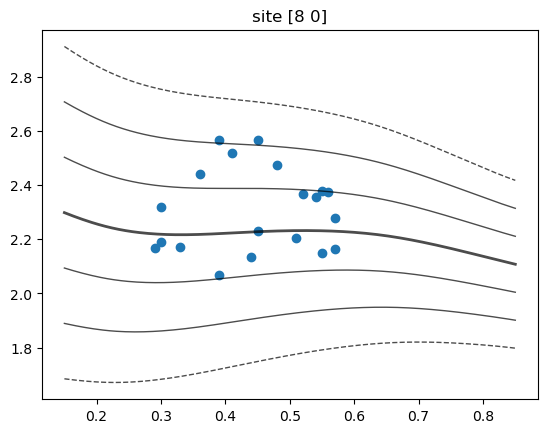

In [250]:
# Plot the original training set data points (site 0) into the centiles
plt.scatter(X_test[batch_effects_test[:,0]==8], Y_test[batch_effects_test[:,0]==8, 0])
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0]))

## Case 1b: Add data points from site 7 into the quantile plot of site 8.

1. Create a forward prediction for the covariate combination of each individual of site 7 for site 8
2. Use yhat and s2 to invert z score of those individuals

Rationale:

The zscores that the model produces are normalized for site. Hence, the z-socres are comparable in z-score space.
In order to convert the data points back into different site spaces, we need to revert the z-score transformation.

$z_{s1,7} = z_8$

$z_7 = \frac{\hat{y}_8 - y}{s_8}$

$z_7 * s_8 - \hat{y_8} = -y$





In [251]:
# Select individuals from site 7

X_test_7=X_test[batch_effects_test[:,0]==7]
n_synthetic_samples = sum(batch_effects_test[:,0]==7)

# Create a batch effect file for forward predictions in site 8
be = np.zeros((n_synthetic_samples,2))
eights = np.ones((n_synthetic_samples,1))*8
be[:,0] = eights[:,0]
be=be.astype(int)

with open('X_test_7_in_8.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_7), file)

X_test_7_path = os.path.join(processing_dir, 'X_test_7_in_8.pkl')

with open('be_8.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(be), file)

be_8_path = os.path.join(processing_dir, 'be_8.pkl')

In [252]:
ptk.normative.predict(covfile=X_test_7_path,
                      inputsuffix='_estimate',
                      respfile=None,
                      tsbefile=be_8_path,
                      model_path=output_path,
                      alg='hbr',
                      outputsuffix='_X_test_7_in_8')

Loading data ...
Prediction by model  1 of 2


Sampling: [y_like]


Sampling: [y_like]


Prediction by model  2 of 2


Writing outputs ...


(array([[2.23973348, 2.24683378],
        [2.22294728, 2.22672089],
        [2.25782451, 2.28361622],
        [2.26434952, 2.26288094],
        [2.23967185, 2.23731315],
        [2.22369728, 2.22644667],
        [2.24437744, 2.24824632],
        [2.26375812, 2.27519935],
        [2.21485305, 2.2072582 ],
        [2.21773618, 2.21234341],
        [2.23648037, 2.24657045],
        [2.26610279, 2.27378447],
        [2.26562256, 2.28659478],
        [2.27337953, 2.28142639],
        [2.25995273, 2.2980891 ],
        [2.26403585, 2.28211632],
        [2.25945289, 2.26318221],
        [2.26377306, 2.25879524],
        [2.25166758, 2.25899253],
        [2.2666076 , 2.26432481],
        [2.23288432, 2.23475848],
        [2.26584293, 2.2710277 ],
        [2.23347557, 2.23889855],
        [2.25098165, 2.26535867],
        [2.25534189, 2.26277939],
        [2.24162729, 2.23845166],
        [2.24671252, 2.26238286],
        [2.24226962, 2.24806004],
        [2.23664248, 2.23821347],
        [2.262

### load the yhat and s2 for subjects from site 7 for site 8.

In [253]:
yhat_Xtest7in8 = ldpkl(os.path.join(processing_dir, "yhat_Xtest7.pkl"))
ys2_Xtest7in8 = ldpkl(os.path.join(processing_dir, "ys2_Xtest7.pkl"))

In [254]:
z_scores = ldpkl(os.path.join(processing_dir, "Z_estimate.pkl"))

In [255]:
yhat_Xtest7in8[0]
ys2_Xtest7in8[0]

0      0.043898
1      0.037202
2      0.046040
3      0.044789
4      0.042820
         ...   
99     0.041555
100    0.043453
101    0.044574
102    0.041822
103    0.042269
Name: 0, Length: 104, dtype: float64

In [256]:
y_adj = z_scores[batch_effects_test[:,0]==7][0].to_numpy() * ys2_Xtest7in8[0].to_numpy() - yhat_Xtest7in8[0].to_numpy()

In [257]:
y_adj = y_adj * (-1)

Text(0.5, 1.0, 'site [8 0]')

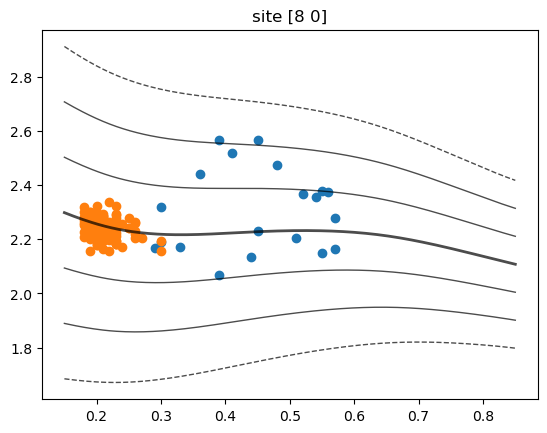

In [258]:
plt.scatter(X_test[batch_effects_test[:,0]==8], Y_test[batch_effects_test[:,0]==8, 0])
plt.scatter(X_test[batch_effects_test[:,0]==7], y_adj)
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0]))

# Transfer model

The transfer works best with an adaptation data set. We are going to use the held-out training data set for that

In [18]:
txfer_output_path = os.path.join(processing_dir,'Transfer')
os.makedirs(txfer_output_path, exist_ok=True)


In [19]:
# load the hold out data

X_adapt = (new_sites_tr['age']/100).to_numpy(dtype=float)
Y_adapt = new_sites_tr[idps].to_numpy(dtype=float)
batch_effects_adapt = new_sites_tr[['sitenum','sex']].to_numpy(dtype=int)

X_test_txfr = (new_sites_te['age']/100).to_numpy(dtype=float)
Y_test_txfr = new_sites_te[idps].to_numpy(dtype=float)
batch_effects_test_txfr = new_sites_te[['sitenum','sex']].to_numpy(dtype=int)

In [20]:
print(batch_effects_test_txfr.shape)
print(batch_effects_adapt.shape)
print(X_adapt.shape)
print(Y_adapt.shape)


(139, 2)
(38, 2)
(38,)
(38, 2)


In [21]:
with open(os.path.join(processing_dir,'X_adaptation.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(X_adapt), file)
with open(os.path.join(processing_dir,'Y_adaptation.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(Y_adapt), file) 
with open(os.path.join(processing_dir,'adbefile.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_adapt), file) 

#%%
# save the dataframes
with open(os.path.join(processing_dir,'X_test_txfr.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_txfr), file)
with open(os.path.join(processing_dir, 'Y_test_txfr.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test_txfr), file) 
with open(os.path.join(processing_dir, 'txbefile.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test_txfr), file) 


In [22]:
batch_effects_adapt

array([[20,  1],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [20,  1],
       [20,  0],
       [20,  1],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  0]])

In [23]:
for idx, measure in enumerate(idps):
    #idx = idx +3
    # create an Y_adaptation and Y_test_txfr for each feature
    
    Y_adaptation_onefeature = Y_adapt[:,idx]
    with open(os.path.join(txfer_output_path,f'{idx+1}'+'_Y_adaptation_onefeature.pkl'), 'wb') as file:
        pickle.dump(pd.DataFrame(Y_adaptation_onefeature), file)
 
    Y_test_txfr_onefeature = Y_test_txfr[:,idx]
    with open(os.path.join(txfer_output_path,f'{idx+1}'+'_Y_test_txfr_onefeature.pkl'), 'wb') as file:
        pickle.dump(pd.DataFrame(Y_test_txfr_onefeature), file)
 
           
    respfile_path = os.path.join(txfer_output_path,f'{idx+1}'+'_Y_adaptation_onefeature.pkl')
    covfile_path = os.path.join(processing_dir, 'X_adaptation.pkl')
    #trbefile = os.path.join(processing_dir, 'adbefile.pkl')
    adbefile = os.path.join(processing_dir, 'adbefile.pkl')
    
    testrespfile_path = os.path.join(txfer_output_path, f'{idx+1}'+'_Y_test_txfr_onefeature.pkl')
    testcovfile_path = os.path.join(processing_dir,'X_test_txfr.pkl')
    #tsbefile = os.path.join(processing_dir, 'txbefile.pkl')
    txbefile = os.path.join(processing_dir, 'txbefile.pkl')
   
    output_path = os.path.join(processing_dir, 'Models/') 
    log_dir = os.path.join(processing_dir, 'log/')
    

    transfer_suffix = '_transfer_'+f'{idx+1}'
    ptk.normative.transfer(covfile=covfile_path, 
                           respfile=respfile_path,
                           trbefile=adbefile,
                           model_type='bspline',
                           linear_sigma = 'True',
                           random_intercept_sigma = 'True',
                           random_slope_sigma = 'True',
                           linear_mu='True',
                           random_intercept_mu='True',
                           random_slope_mu='True',
                           alg='hbr', 
                           model_path = output_path,
                           log_path=log_dir, 
                           binary=True,
                           output_path=txfer_output_path, 
                           testcov=testcovfile_path,
                           tsbefile=txbefile,
                           #trbefile=trbefile,
                           testresp = testrespfile_path,
                           inputsuffix = "_estimate",
                           outputsuffix=transfer_suffix, 
                           savemodel=True)

Loading data ...
Using HBR transform...
Transferring model  1 of 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Evaluating the model ...
Writing outputs ...
Loading data ...
Using HBR transform...
Transferring model  1 of 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Evaluating the model ...
Writing outputs ...


In [24]:
yhat_transfer = ldpkl(os.path.join(processing_dir, "yhat_transfer1.pkl"))
yhat_transfer

ys2_transfer = ldpkl(os.path.join(processing_dir, "ys2_transfer1.pkl"))
ys2_transfer

,0
0,0.023318
1,0.025590
2,0.025221
3,0.022967
4,0.024781
...,...
134,0.015815
135,0.016013
136,0.027913
137,0.018807


In [53]:
EV = pd.read_pickle(os.path.join(processing_dir, 'EXPV_transfer2.pkl'))
print(EV)

          0
0  0.047114


In [56]:
# create dummy zscores
zscores = np.arange(-3,4)[:,np.newaxis]

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
# Create sythetic X achsis
n_synthetic_samples = 200
synthetic_X = np.linspace(0.15, 0.85, n_synthetic_samples)[:,np.newaxis]
# choose type of site effect by cerating intercept offset (or not)
be = np.zeros((n_synthetic_samples,2))
twenties = np.ones((n_synthetic_samples,1))*21
be[:,0] = twenties[:,0]
be=be.astype(int)

In [57]:
nm_transfer1 = ldpkl(os.path.join(txfer_output_path, 'NM_0_0_transfer1.pkl'))

In [58]:
# We generate an object to hold the quantiles
q = nm_transfer1.get_mcmc_quantiles(synthetic_X, be,  zscores)

Sampling: [y_like]


Text(0.5, 1.0, 'site [21  0]')

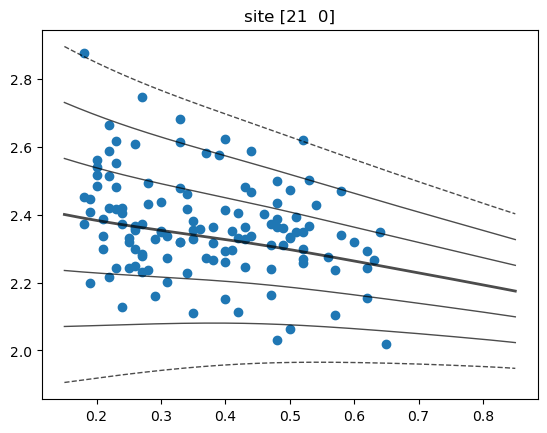

In [61]:
# Plot the data onto the centiles obtained from the transfer model

plt.scatter(X_test_txfr[batch_effects_test_txfr[:,0]==21], Y_test_txfr[(batch_effects_test_txfr[:,0]==21),0])
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0]))